# Dem in Hydrology

In [ ]:
import numpy as np
from osgeo import gdal, osr

def save_filled_dem(filled_dem, output_file_path, input_dem_file_path):
    # خواندن اطلاعات مکانی و ترتیبی از فایل DEM اصلی
    input_dem_dataset = gdal.Open(input_dem_file_path)
    geotransform = input_dem_dataset.GetGeoTransform()
    projection = input_dem_dataset.GetProjection()

    # تعیین ابعاد و نوع داده برای نقشه فیل
    rows, cols = filled_dem.shape
    data_type = gdal.GDT_Float32

    # ایجاد فایل خروجی با استفاده از GDAL
    driver = gdal.GetDriverByName('GTiff')
    output_dataset = driver.Create(output_file_path, cols, rows, 1, data_type)

    # تنظیم اطلاعات مکانی و ترتیبی برای نقشه فیل
    output_dataset.SetGeoTransform(geotransform)
    output_dataset.SetProjection(projection)

    # نوشتن داده‌های نقشه فیل در فایل خروجی
    output_band = output_dataset.GetRasterBand(1)
    output_band.WriteArray(filled_dem)

    # بستن فایل‌های دیتاست
    output_band.FlushCache()
    output_dataset = None
    input_dem_dataset = None

    print(f"Filled DEM saved successfully as: {output_file_path}")


# مسیر فایل DEM اصلی
input_dem_file_path = "/content/dem.tif"

# مسیر فایل خروجی برای نقشه فیل
output_filled_dem_file_path = "/content/demFill.tif"

# فراخوانی تابع fill_algorithm برای پر کردن NaN‌ها در DEM
# در اینجا filled_dem_array باید توسط fill_algorithm تولید شود
filled_dem_array = fill_algorithm(dem_array)

# ذخیره نقشه فیل
save_filled_dem(filled_dem_array, output_filled_dem_file_path, input_dem_file_path)


Filled DEM saved successfully as: /content/demFill.tif


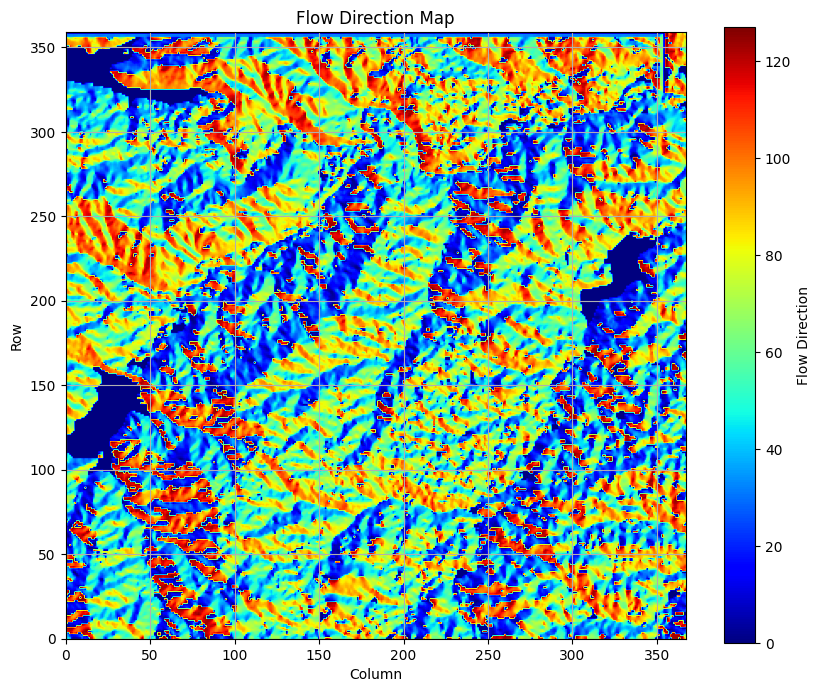

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from osgeo import gdal

def calculate_flow_direction(dem):
    dz_dx = sobel(dem, axis=1)  # تفاوت ارتفاعات در جهت x
    dz_dy = sobel(dem, axis=0)  # تفاوت ارتفاعات در جهت y
    flow_direction = np.arctan2(-dz_dy, -dz_dx)
    flow_direction = np.degrees(flow_direction) + 180  # تبدیل رادیان به درجه و افزودن 180 درجه
    flow_direction = (flow_direction / 360) * 128  # تبدیل مقادیر به بازه 0 تا 128
    return flow_direction.astype(int)  # تبدیل به نوع داده integer

# مسیر فایل fill
path_to_fill_file = "/content/demFill.tif"

# خواندن فایل fill
fill_data = gdal.Open(path_to_fill_file)
fill_array = fill_data.ReadAsArray()

# محاسبه جهت جریان آب
flow_direction = calculate_flow_direction(fill_array)

# نمایش نقشه جهت جریان آب
plt.figure(figsize=(10, 8))
plt.imshow(flow_direction, cmap='jet', extent=(0, fill_array.shape[1], 0, fill_array.shape[0]))
plt.colorbar(label='Flow Direction')
plt.title('Flow Direction Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(True)
plt.show()


In [ ]:
from osgeo import gdal, osr

def save_flow_direction(flow_direction, output_path):
    # ابعاد نقشه جهت جریان
    rows, cols = flow_direction.shape

    # ایجاد فایل خروجی
    driver = gdal.GetDriverByName('GTiff')
    flow_direction_ds = driver.Create(output_path, cols, rows, 1, gdal.GDT_Float32)

    # ذخیره نقشه جهت جریان
    flow_direction_ds.GetRasterBand(1).WriteArray(flow_direction)

    # تنظیم متاداداده‌ها
    flow_direction_ds.GetRasterBand(1).SetNoDataValue(-9999)

    # تعیین سیستم مختصاتی
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)  # WGS84
    flow_direction_ds.SetProjection(srs.ExportToWkt())

    # آزاد کردن حافظه
    flow_direction_ds = None

# مسیر فایل خروجی
output_path = "/content/flow_direction.tif"

# ذخیره نقشه جهت جریان
save_flow_direction(flow_direction, output_path)


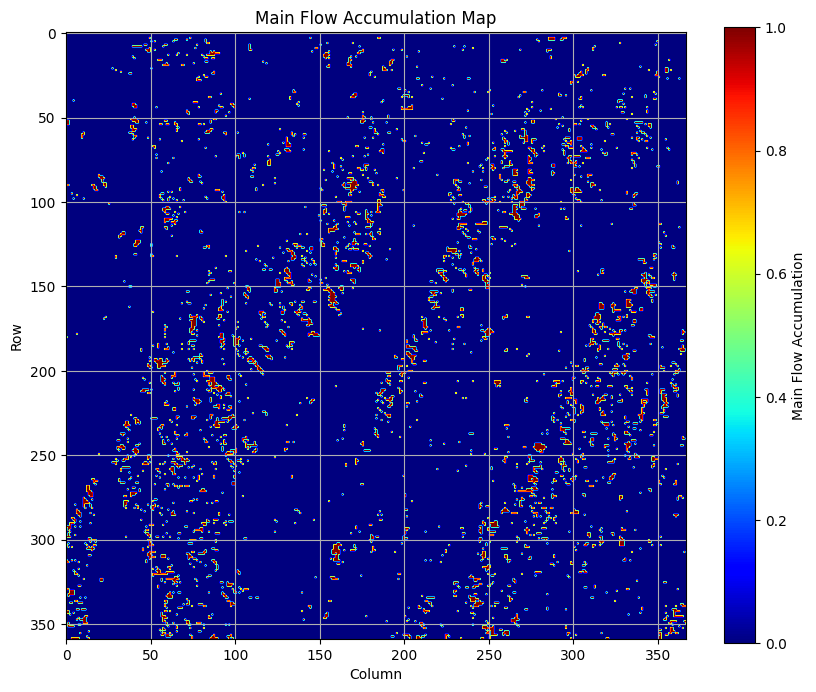

In [ ]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

def calculate_main_flow_accumulation(flow_direction):
    # جهت‌های جریان اصلی (اعداد صحیح از 1 تا 8)
    main_flow_directions = np.arange(1, 9)

    # محاسبه تجمع جریان برای جریان‌های اصلی
    flow_accumulation_main = np.zeros_like(flow_direction, dtype=np.float32)
    for direction in main_flow_directions:
        flow_accumulation_main[flow_direction == direction] += 1

    return flow_accumulation_main

# مسیر فایل جهت جریان
flow_direction_path = "/content/flow_direction.tif"

# خواندن فایل جهت جریان
flow_direction_data = gdal.Open(flow_direction_path)
flow_direction = flow_direction_data.ReadAsArray()

# محاسبه تجمع جریان برای جریان‌های اصلی
flow_accumulation_main = calculate_main_flow_accumulation(flow_direction)

# نمایش نقشه تجمع جریان برای جریان‌های اصلی
plt.figure(figsize=(10, 8))
plt.imshow(flow_accumulation_main, cmap='jet')
plt.colorbar(label='Main Flow Accumulation')
plt.title('Main Flow Accumulation Map')
plt.xlabel('Column')
plt.ylabel('Row')
plt.grid(True)
plt.show()


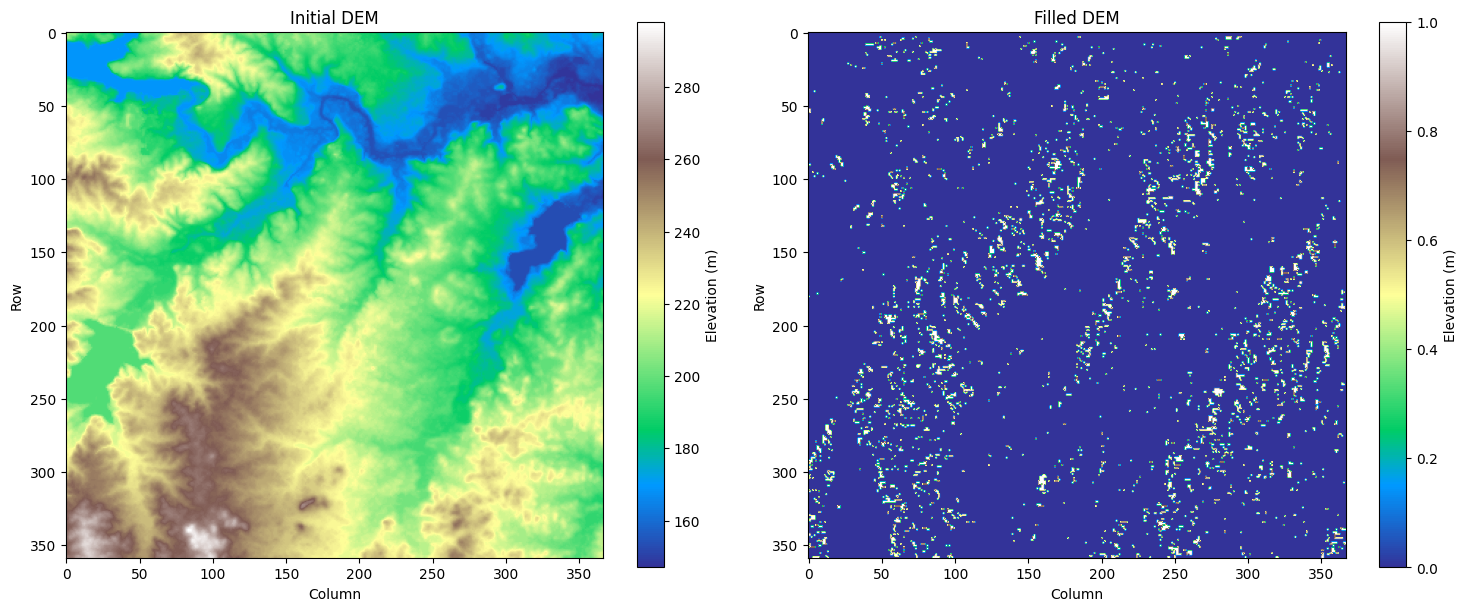

In [ ]:
import matplotlib.pyplot as plt

# ساخت دو نمودار کنار هم
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# نمایش دم اولیه در نمودار اول
img1 = axs[0].imshow(dem_array, cmap='terrain')
axs[0].set_title('Initial DEM')
axs[0].set_xlabel('Column')
axs[0].set_ylabel('Row')
fig.colorbar(img1, ax=axs[0], label='Elevation (m)')

# نمایش نقشه فیل شده در نمودار دوم
img2 = axs[1].imshow(flow_accumulation_main, cmap='terrain')
axs[1].set_title('Filled DEM')
axs[1].set_xlabel('Column')
axs[1].set_ylabel('Row')
fig.colorbar(img2, ax=axs[1], label='Elevation (m)')

# نمایش نمودارها
plt.tight_layout()
plt.show()
